# Ensemble Kalman Filtering
A little note: doing linear algebra with NumPy can be slightly annoying due to the fact that it automatically converts [1 x N] and [N x 1] arrays to row vectors.  In addition, some functions do not work on scalar values.  For instance np.linalg.inv(X) takes the inverse of matrix X.  If X is a 1D matrix, numpy converts it to a scalar automatically, and np.linalg.inv(X) does not work.  You must do np.linalg.inv(np.atleast_2d(X)) to get it to compute.  These are extra operations whenever working in 2-D, and makes the code super messy.  So, I am dividing the impelmentation into a 1-D and 2-D version.
## Goals
### Understand the Ensemble Kalman Filtering Algorithm (EnKF)
### Understand the computational bottlenecks of EnKF
### Understand the special cases for accelerating EnKF, and limitations of those approaches
### Understand the numerical tricks for accelerating EnKF
### Understand how to implement the EnKF and variants in Python

In [953]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from abc import ABCMeta, abstractmethod

In [954]:
class ensemble_kalman_filter:
    def __init__(self):
        # Problem Dimensions, limit to 1-D currently
        self._num_ensemble_members = None
        
        # State Estimate
        self._current_state_estimate = None
        
        self._current_measurement_estimate = None
        
        self._current_state_covariance = None
        
        self._current_cross_covariance = None
        
        self._current_kalman_gain = None
        
        self._current_time = 1
        
        # Ensemble
        self._current_ensemble = None
        self._current_ensemble_measurements = None
        
        # Operators
        self._evolution_operator = None
        self._forward_operator = None
        self._evolution_covariance = None
        self._forward_covariance = None  
        pass
    
    def initialize_problem(self, initial_state, \
                           initial_error, \
                           base_time_step, \
                           num_measurement_dimensions, \
                           ensemble_size, \
                           options = None):
        # set the problem dimensions
        self._num_ensemble_members = ensemble_size
        self._current_state_estimate = initial_state
        self._current_state_covariance = initial_error
        self._num_measurement_dimensions = num_measurement_dimensions
        pass
    
    def set_ensemble_size(self, nPoints):
        self._num_ensemble_members = nPoints
        pass
    
    def set_state_evolution_model(self, function_handle):
        self._evolution_operator = function_handle
        pass
    
    def set_state_evolution_model_covariance(self, covariance_matrix):
        self._evolution_covariance = covariance_matrix
        pass
    
    def set_forward_model(self, function_handle):
        self._forward_operator = function_handle
        pass
    
    def set_forward_model_covariance(self, covariance_matrix):
        self._forward_covariance = covariance_matrix
        pass
    
    def assimilate_data(self, measurment, time):
        self._generate_ensemble()
        self._evolve_system(time)
        self._simulate_measurements()
        self._forecast_expected_state()
        self._forecast_expected_state_covariance()
        self._forecast_expected_measurement()
        self._forecast_expected_measurement_covariance()
        self._estimate_cross_covariance()
        self._estimate_kalman_gain()
        self._update_state_and_covariance_using_measurement(measurment)
        
        return self._current_state_estimate, self._current_state_covariance
    
    @abstractmethod
    def _generate_ensemble(self):
        pass
    @abstractmethod
    def _evolve_system(self, time):
        pass
    @abstractmethod
    def _simulate_measurements(self):
        pass
    @abstractmethod
    def _forecast_expected_state(self):
        pass
    @abstractmethod
    def _forecast_expected_state_covariance(self):
        pass
    @abstractmethod
    def _forecast_expected_measurement(self):
        pass
    @abstractmethod
    def _forecast_expected_measurement_covariance(self):
        pass
    @abstractmethod
    def _estimate_cross_covariance(self):
        pass
    @abstractmethod
    def _estimate_kalman_gain(self):
        pass
    @abstractmethod
    def _update_state_and_covariance_using_measurement(self, measurement):
        pass
    
    

In [955]:
# Basic EnKF algorithm in one dimension
class ensemble_kalman_filter_1d(ensemble_kalman_filter):
    
    def _generate_ensemble(self):
        self._current_ensemble = np.random.normal(self._current_state_estimate, \
                                                  self._current_state_covariance**0.5, \
                                                  size = self._num_ensemble_members)
        pass
    
    def _evolve_system(self, time):
        self._current_ensemble = self._evolution_operator(self._current_ensemble, time, nSamples = self._num_ensemble_members)
        pass
    
    def _simulate_measurements(self):
        self._current_ensemble_measurements = self._forward_operator(self._current_ensemble, noise = False)
        pass
    
    def _forecast_expected_state(self):
        self._current_state_estimate = np.mean(self._current_ensemble)
        pass
    
    def _forecast_expected_state_covariance(self):
        self._current_state_covariance = np.var(self._current_ensemble)
        pass
    
    def _forecast_expected_measurement(self):
        self._current_measurement_estimate = np.mean(self._current_ensemble_measurements)
        pass
    
    def _forecast_expected_measurement_covariance(self):
        self._current_measurement_covariance = self._forward_covariance + np.var(self._current_ensemble_measurements)
        pass
    
    def _estimate_cross_covariance(self):
        self._current_cross_covariance  = 0
        for i in range(self._num_ensemble_members):
            self._current_cross_covariance  += (self._current_ensemble[i] - self._current_state_estimate)*(self._current_ensemble_measurements[i] - self._current_measurement_estimate)
        
        self._current_cross_covariance /= self._num_ensemble_members
        pass
    
    def _estimate_kalman_gain(self):
        self._current_kalman_gain = self._current_cross_covariance/self._current_measurement_covariance
        pass
    
    def _update_state_and_covariance_using_measurement(self, measurement):
        # update expected value
        self._current_state_estimate += self._current_kalman_gain*(measurement - self._current_measurement_estimate)  
        # update error (covariance) estimate
        self._current_state_covariance -= self._current_kalman_gain * self._current_measurement_covariance * self._current_kalman_gain
        pass

In [956]:
enkf = ensemble_kalman_filter_1d()

In [957]:
def evolution(state, time, nSamples = 1):
    new_state = state/2.0 + 25.0*state/(1 + state**2) + 8.0*np.cos(1.2 * time)
    noise = np.random.normal(0, 10**0.5, size = nSamples)
    return new_state + noise


In [958]:
def measurement_model(state, noise = True, n_measurement_dims = 1, nSamples = 1):
    precise_measurement = (state**2.0) / 20.0
    if noise:
        precise_measurement += np.random.normal(0, 1, size = nSamples)
    return precise_measurement

In [959]:
enkf.set_forward_model(measurement_model)
enkf.set_forward_model_covariance(1) 

enkf.set_ensemble_size(10000)

enkf.set_state_evolution_model(evolution)
enkf.set_state_evolution_model_covariance(10)


In [960]:
times = np.array(range(1, 71))
initial_state = 0
initial_state_covariance = 10
states = np.zeros([1, 70])
measurements = np.zeros_like(states)
estimate = np.zeros_like(states)
error = np.zeros(70)
enkf.initialize_problem(initial_state, initial_state_covariance, 1, 1, 100)

In [961]:
for iTime, time in enumerate(times):
    if time == 1:
        states[:, iTime] = initial_state
        estimate[:, iTime] = initial_state
    else:
        states[:, iTime] = evolution(states[:, iTime - 1], time, nSamples = 1)
    measurements[:, iTime] = measurement_model(states[:, iTime])
    estimate[:,iTime], error[iTime] = enkf.assimilate_data(measurements[:, iTime], time)

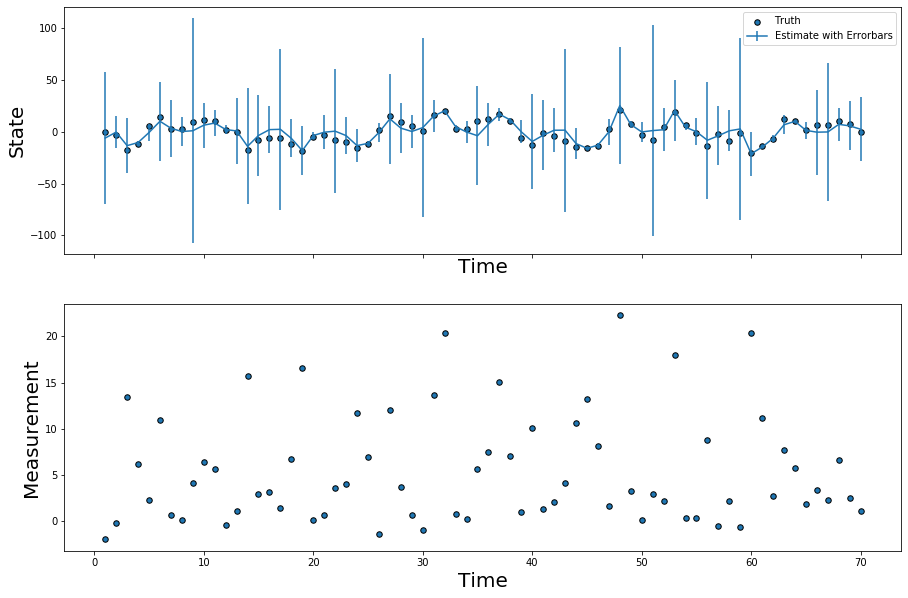

In [962]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 10])
ax[0].scatter(times, states[0], edgecolors = 'black', s = 30)
ax[0].errorbar(times, estimate[0], yerr = 1.*error)
ax[1].scatter(times, measurements[0], edgecolors = 'black', s = 30)
for axis in ax:
    axis.set_xlabel("Time", fontsize = 20)

ax[0].set_ylabel("State", fontsize = 20)
ax[1].set_ylabel("Measurement", fontsize = 20)
ax[0].legend(["Truth", "Estimate with Errorbars"])

Things are slightly different in multiple dimensions.  Specifically:
we must use np.random.multivariate_normal to generate samples.  The syntax, and the 

In [963]:
mean_value = np.zeros(3)
covariance = np.eye(3)

random_multivariate_samples = np.random.multivariate_normal(mean_value, covariance, size = 4)
random_multivariate_samples

array([[-0.64762675, -0.50293305,  2.13993214],
       [ 2.21390963,  1.13714951,  1.54418437],
       [ 0.33828615,  0.08041322, -1.33993276],
       [-0.29577467,  0.20192097,  0.6450013 ]])

This is contrary to typical linear algebra operations, but consistent with most machine learning implementations, which considers sample matrices as [nSamples x nDim] or [nSamples x nFeatures] depending on terminology.

In [942]:
A = np.arange(9).reshape([3,3])
x = np.array([1, 2, 3])
print(A)
print(x)

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[1 2 3]


In [943]:
A*x

array([[ 0,  2,  6],
       [ 3,  8, 15],
       [ 6, 14, 24]])

In [944]:
A*x.T

array([[ 0,  2,  6],
       [ 3,  8, 15],
       [ 6, 14, 24]])

In [945]:
np.dot(A, x)

array([ 8, 26, 44])

In [946]:
np.var(random_multivariate_samples)

1.0953852908903137

Not exactly what we were expecting.

In [947]:
np.cov(random_multivariate_samples)

array([[ 0.23824432, -0.19693956, -0.54361789, -0.44995206],
       [-0.19693956,  0.36145727,  0.43577343, -0.12587565],
       [-0.54361789,  0.43577343,  1.24133958,  1.06075681],
       [-0.44995206, -0.12587565,  1.06075681,  2.09725401]])

Also not what I was expecting

In [948]:
np.cov(random_multivariate_samples.T)

array([[ 2.28727522e+00, -1.57502425e-01,  9.61150415e-01],
       [-1.57502425e-01,  1.55306466e-02, -2.18656894e-03],
       [ 9.61150415e-01, -2.18656894e-03,  1.36230441e+00]])

So, even NumPy is not consistent with its own idea of sizing random variable arrays.  It is important to understand how to implement linear algebra operations in Numpy, and to not get caught off guard by its broadcasting rules.  From the NumPy documentation:
" numpy.cov(X) : X is a 1-D or 2-D array containing multiple variables and observations.  Each row of X represents a variable, and each column a single observation of all those variables."

So, it is expecting an array of [nFeatures x nSamples], but the multivariate_normal random number generator returns [nSamples x nFeatures].  We must keep this in mind whenever writing our function calls.

In [949]:
np.mean(random_multivariate_samples)

0.17594856240929588

In [951]:
np.mean(random_multivariate_samples, axis = 1)

array([ 1.24494686,  0.16632243, -0.51502349, -0.19245155])

In [952]:
np.mean(random_multivariate_samples, axis = 0)

array([-0.2706797 ,  0.74430469,  0.0542207 ])

We will also need to subtract the mean value from the covariance matrix.  Lets get the dimensions correct for this

In [967]:
A = np.arange(9).reshape([3,3])
b = np.array([1, 2, 3])
A

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [968]:
b

array([1, 2, 3])

In [969]:
A - b

array([[-1, -1, -1],
       [ 2,  2,  2],
       [ 5,  5,  5]])

In [970]:
A - b.T

array([[-1, -1, -1],
       [ 2,  2,  2],
       [ 5,  5,  5]])

In [974]:
A - b.reshape([b.shape[0], 1])

array([[-1,  0,  1],
       [ 1,  2,  3],
       [ 3,  4,  5]])

In [1126]:
nSamples = 10
nStateDim = 2
nMeasDim = 3

state_samples = np.random.multivariate_normal([0,0], np.eye(2), nSamples)
meas_samples = np.random.multivariate_normal([0,0,0], np.eye(3), nSamples)

state_mean = np.mean(state_samples, axis = 0)
meas_mean = np.mean(meas_samples, axis = 0)

print(state_mean)
print(meas_mean)

[-0.09766396  0.33058938]
[-0.27017359 -0.11005618 -0.56539946]


In [1124]:
state_samples[1,:]

array([ 0.28506526, -1.23933356])

In [1127]:
meas_samples[1,:]

array([-1.25175952,  1.90126124, -0.76948927])

In [1128]:
state_samples[1,:] - state_mean

array([-0.83291139,  0.82050764])

In [1129]:
meas_samples[1,:] - meas_mean

array([-0.98158593,  2.01131742, -0.20408981])

In [1131]:
(state_samples[1,:] - state_mean)*(meas_samples[1,:] - meas_mean)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [1132]:
(state_samples[1,:] - state_mean)@(meas_samples[1,:] - meas_mean)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [1134]:
(state_samples[1,:] - state_mean).T*(meas_samples[1,:] - meas_mean)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [1135]:
(state_samples[1,:] - state_mean).T@(meas_samples[1,:] - meas_mean)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [1137]:
(state_samples[1,:] - state_mean).reshape([2,1])@(meas_samples[1,:] - meas_mean).reshape([1,3])

array([[ 0.8175741 , -1.67524918,  0.16998873],
       [-0.80539876,  1.65030131, -0.16745725]])


(self._current_ensemble[i,:] - self._current_state_estimate).reshape([self._numStateDimensions, 1])

(self._current_ensemble_measurements[i,:] - self._current_measurement_estimate).reshape([1, self._numMeasurementDimensions])

In [1533]:
# Basic EnKF algorithm in multiple dimensions
class ensemble_kalman_filter_multivariate(ensemble_kalman_filter_1d):
    # All comments describe changes from the ensemble_kalman_filter_1d implementation.  
    
    def __init__(self, numStateDimensions, numMeasurementDimensions):
        super().__init__() # inherit the superclass's __init__attributes
        # add two new attributes
        self._numStateDimensions = numStateDimensions
        self._numMeasurementDimensions = numMeasurementDimensions
        pass
    
    def _generate_ensemble(self):
        # change random sampler to multivariate_normal.  Returns nSample x nStateDimension sample matrix 
        self._current_ensemble = np.random.multivariate_normal(self._current_state_estimate, \
                                                  self._current_state_covariance, \
                                                  size = self._num_ensemble_members)
        pass
    
    def _forecast_expected_state(self):
        # random sampler returns nSample x nStateDimension sample matrix, so we must take mean over axis = 0
        self._current_state_estimate = np.mean(self._current_ensemble, axis = 0)
        pass
    
    def _forecast_expected_state_covariance(self):
        # random sampler returns nSample x nStateDimension sample matrix, so we must covariance of the transpose
        # b/c of what np.cov expects [nStateDimension x nSample]
        self._current_state_covariance = np.cov(self._current_ensemble.T)
        pass
    
    def _forecast_expected_measurement(self):
        # For consistancy with transposes and taking means, we assume that
        # our forward model returns an
        # nSample x nMeasurementDimension sample matrix, 
        # so we must take mean over axis = 0
        self._current_measurement_estimate = np.mean(self._current_ensemble_measurements, axis = 0)
        pass
    
    def _forecast_expected_measurement_covariance(self):
        # For consistancy with transposes and taking means, we assume that
        # our forward model returns an
        # nSample x nMeasurementDimension sample matrix, 
        # so we must take np.cov of the transpose of our ensemble measurements
        self._current_measurement_covariance = self._forward_covariance + np.cov(self._current_ensemble_measurements.T)
        pass
    
    def _estimate_cross_covariance(self):
        # recall, _current_ensemble is [nSamples x nStateDimensions] for indexing
        # _current_state_estimate is a row vector with nStateDimensions entries
        # _current_ensemble_measurements is [nSamples x nMeasurementDimensions]
        # _current_measurement_estimate is a row vector with nMeasurementDimensions entries
        # must reshape
        
        # _estimate_cross_covariance is the last time the ensemble is used before being redrawn
        # thus we can overwrite it for these calculations to save memory
        
        self._current_cross_covariance  = np.zeros([self._numStateDimensions, self._numMeasurementDimensions])
        
        for i in range(self._num_ensemble_members):
            self._current_cross_covariance  += (self._current_ensemble[i,:] - self._current_state_estimate).reshape([self._numStateDimensions, 1])@(self._current_ensemble_measurements[i,:] - self._current_measurement_estimate).reshape([1, self._numMeasurementDimensions])
        
        self._current_cross_covariance /= self._num_ensemble_members # elementwise division by a scalar
        pass
    
    def _estimate_kalman_gain(self):
        # Now we are dealing with matrix math instead of scalar math.  We make approprate changes
        self._current_kalman_gain = self._current_cross_covariance @ np.linalg.inv(self._current_measurement_covariance)
        pass
    
    def _update_state_and_covariance_using_measurement(self, measurement):
        # update expected value
        temp = self._current_kalman_gain@(np.atleast_2d(measurement).T - np.atleast_2d(self._current_measurement_estimate).T)  

        self._current_state_estimate = self._current_state_estimate + temp[0]
        # update error (covariance) estimate
        self._current_state_covariance -= self._current_kalman_gain @ self._current_measurement_covariance @ self._current_kalman_gain.T
        pass

In [1534]:
def evolution_2d(state, time, nSamples = 1):
    new_state = state/2.0 + 25.0*state/(1 + state**2) + 8.0*np.cos(1.2 * time)
    
    noise = np.random.multivariate_normal(np.zeros(2), 10*np.eye(2), size = nSamples)
    return new_state + noise

def measurement_model_2d_plus_equals(state, noise = True, n_measurement_dims = 2, nSamples = 1):
    precise_measurement = (state**2.0) / 20.0
    if noise:
        precise_measurement +=  np.random.multivariate_normal(np.zeros(2), np.eye(2), size = nSamples)
    return precise_measurement

def measurement_model_2d(state, noise = True, n_measurement_dims = 2, nSamples = 1):
    precise_measurement = (state**2.0) / 20.0
    if noise:
        precise_measurement  = precise_measurement + np.random.multivariate_normal(np.zeros(2), np.eye(2), size = nSamples)
    return precise_measurement

In [1535]:
# recall, our ensemble will be of [nSamples x nDimensions], as will be the multivariate_normal samples

In [1536]:
measurement_model_2d_plus_equals(np.array([1, 1]))

ValueError: non-broadcastable output operand with shape (2,) doesn't match the broadcast shape (1,2)

In [1537]:
measurement_model_2d(np.array([1, 1]))

array([[1.0613558 , 1.29350182]])

In [1538]:
enkf_mv = ensemble_kalman_filter_multivariate(2, 2)

In [1545]:
enkf_mv.set_forward_model(measurement_model_2d)
enkf_mv.set_forward_model_covariance(np.eye(2)) 

enkf_mv.set_ensemble_size(100)

enkf_mv.set_state_evolution_model(evolution_2d)
enkf_mv.set_state_evolution_model_covariance(10*np.eye(2))


In [1546]:
times = np.array(range(1, 71))
initial_state = np.array([-5,10])
initial_state_covariance = 10*np.eye(2)
states = np.zeros([2, 70])
measurements = np.zeros_like(states)
estimate = np.zeros_like(states)
error = np.zeros([2,2,70])
enkf_mv.initialize_problem(initial_state, initial_state_covariance, 1, 1, 100)

In [1547]:
for iTime, time in enumerate(times):
    if time == 1:
        states[:, iTime] = initial_state
        estimate[:, iTime] = initial_state
    else:
        states[:, iTime] = evolution_2d(states[:, iTime - 1], time, nSamples = 1)
    measurements[:, iTime] = measurement_model_2d(states[:, iTime])
    estimate[:,iTime], error[:,:, iTime] = enkf_mv.assimilate_data(measurements[:, iTime], time)

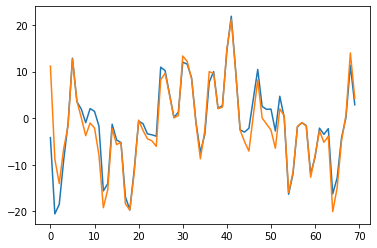

In [1548]:
plt.plot(estimate[0])
plt.plot(estimate[1])

In [1549]:
error.shape

(2, 2, 70)

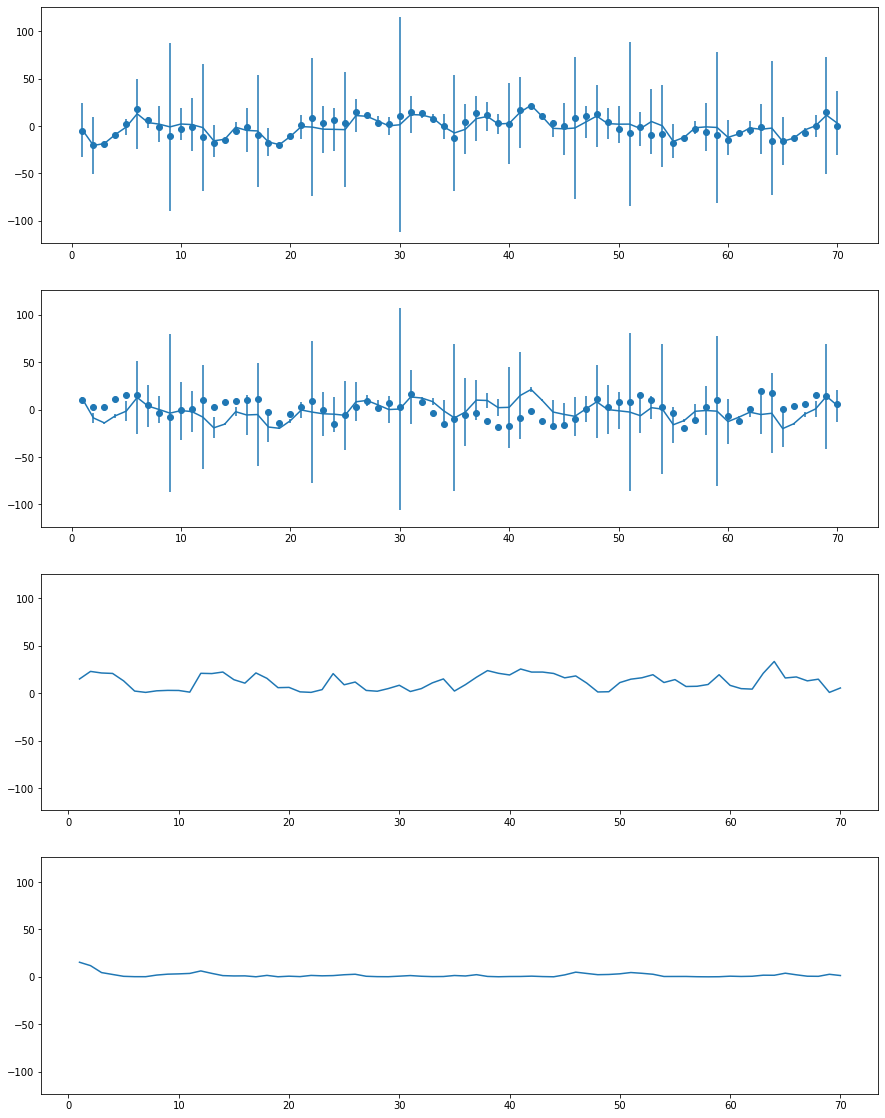

In [1552]:
fig, axes = plt.subplots(nrows = 4, ncols = 1, figsize = [15, 20], sharey = True)

axes[0].errorbar(times, estimate[0], yerr = error[0,0,:])
axes[0].scatter(times, states[0])

axes[1].errorbar(times, estimate[1], yerr = error[1,1,:])
axes[1].scatter(times, states[1])

axes[2].plot(times, abs(states[1] - states[0]))

axes[3].plot(times, abs(estimate[0] - estimate[1]))

In [67]:
for i in range(40):
    for j in range(40):
        cova[i,j] = 0.9**(abs(i - j))
        
print(cova)

[[1.         0.9        0.81       ... 0.02027556 0.018248   0.0164232 ]
 [0.9        1.         0.9        ... 0.0225284  0.02027556 0.018248  ]
 [0.81       0.9        1.         ... 0.02503156 0.0225284  0.02027556]
 ...
 [0.02027556 0.0225284  0.02503156 ... 1.         0.9        0.81      ]
 [0.018248   0.02027556 0.0225284  ... 0.9        1.         0.9       ]
 [0.0164232  0.018248   0.02027556 ... 0.81       0.9        1.        ]]


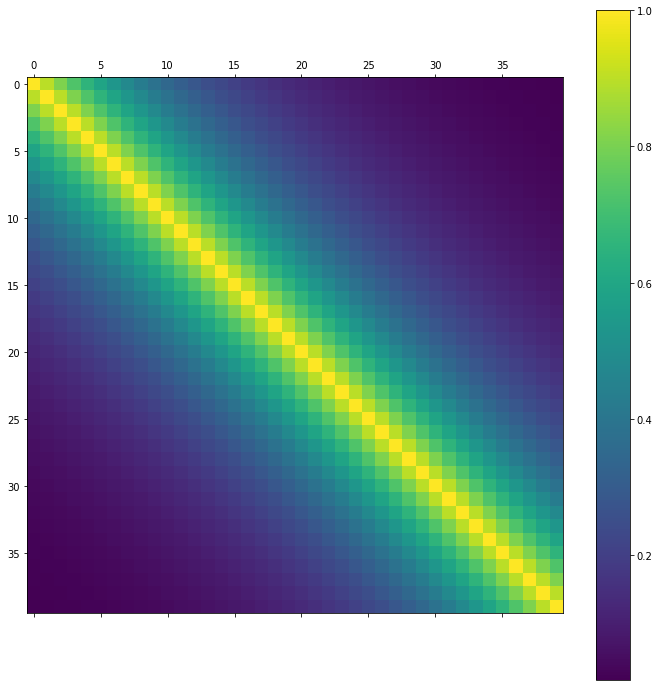

In [68]:
plt.figure(figsize=[12,12])
plt.matshow(cova, fignum=1)
plt.colorbar()

Text(0, 0.5, 'Measurement')

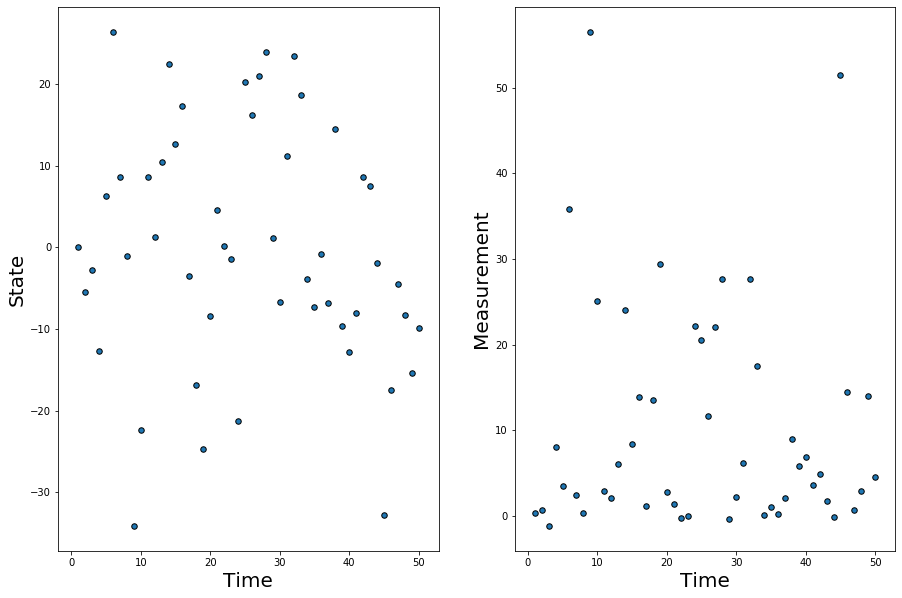

In [106]:
times = np.array(range(1, 51))
initial_state = 0
states = np.zeros([1, 50])
measurements = np.zeros_like(states)
for iTime, time in enumerate(times):
    if time == 1:
        states[:, iTime] = initial_state
    else:
        states[:, iTime] = evolution(states[0, iTime - 1], time)
    measurements[:, iTime] = measurement_model(states[0, iTime])

fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, figsize = [15, 10])
ax[0].scatter(times, states[0], edgecolors = 'black', s = 30)
ax[1].scatter(times, measurements[0], edgecolors = 'black', s = 30)
for axis in ax:
    axis.set_xlabel("Time", fontsize = 20)

ax[0].set_ylabel("State", fontsize = 20)
ax[1].set_ylabel("Measurement", fontsize = 20)